In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/RTGCN/

/content/drive/MyDrive/RTGCN


In [ ]:
!pip install -r requirements.txt

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

### **NEWS WEB SCRAPPING**

In [ ]:
import requests
import pandas as pd
import xmltodict
import time
from datetime import datetime

# Load NIFTY 50 stock list
nifty50_df = pd.read_csv("nifty50list.csv")

# Create a list of company names and symbols
companies = nifty50_df[["Company Name", "Symbol"]].to_dict(orient="records")

# Base Google News RSS URL
RSS_BASE_URL = "https://news.google.com/rss/search?q={query}&hl=en-IN&gl=IN&ceid=IN:en"

# Function to fetch news for a given company
def fetch_company_news(company_name, symbol):
    """Fetch news for a specific NIFTY 50 stock"""
    query = f"{company_name} stock".replace(" ", "+")  # Format query for URL
    rss_url = RSS_BASE_URL.format(query=query)

    try:
        response = requests.get(rss_url)
        if response.status_code != 200:
            return []

        data = xmltodict.parse(response.content)
        articles = data["rss"]["channel"].get("item", [])  # Extract articles

        news_list = []
        if isinstance(articles, list):
            for article in articles:
                # Extract & convert date to YYYY-MM-DD format
                pub_date = article.get("pubDate", "")
                if pub_date:
                    pub_date = datetime.strptime(pub_date, "%a, %d %b %Y %H:%M:%S %Z").strftime("%Y-%m-%d")

                news_list.append({
                    "date": pub_date,  # Store the extracted date
                    "headline": article["title"],
                    "url": article["link"],
                    "source": article.get("source", "Unknown"),
                    "symbol": symbol  # Assign stock symbol
                })

        return news_list

    except Exception as e:
        print(f"Error fetching news for {company_name}: {e}")
        return []

# Fetch news for each company
all_news = []
for company in companies:
    news = fetch_company_news(company["Company Name"], company["Symbol"])
    all_news.extend(news)
    time.sleep(1)  # Sleep to avoid rate limits

# Convert to DataFrame and save CSV
news_df = pd.DataFrame(all_news)

# Ensure 'date' column is properly formatted
news_df["date"] = pd.to_datetime(news_df["date"], errors="coerce").dt.strftime("%Y-%m-%d")

# Save with proper structure
news_df.to_csv("nifty50_stock_news.csv", index=False)

print(f"✅ Scraped {len(news_df)} stock-specific news articles with dates. Saved to nifty50_stock_news_with_dates.csv")


✅ Scraped 5042 stock-specific news articles with dates. Saved to nifty50_stock_news_with_dates.csv


In [ ]:
!pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime
from bs4 import BeautifulSoup
from googlesearch import search
from tqdm import tqdm  # Progress bar

# Define stock name
company_name = "HDFCBANK"

# Define historical time range (last 3 years)
start_year = datetime.now().year - 3
end_year = datetime.now().year

# Store news data
news_data = []

# Function to fetch news links using Google Search
def get_news_links(year):
    query = f"{company_name} stock news after:{year}-01-01 before:{year}-12-31"
    news_links = []

    try:
        for url in search(query, num=100, stop=100, pause=2):  # Get 100 news articles per year
            news_links.append(url)
            time.sleep(1)  # Avoid Google blocking
    except Exception as e:
        print(f"❌ Error fetching links for {company_name} ({year}): {e}")

    return news_links

# Function to scrape news headlines from article URLs
def scrape_news_details(news_url):
    try:
        response = requests.get(news_url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        # Extract headline
        headline = soup.find("h1")
        if headline:
            headline = headline.text.strip()
        else:
            headline = "Unknown Headline"

        return {"headline": headline, "url": news_url}

    except Exception as e:
        print(f"❌ Error scraping {news_url}: {e}")
        return None

# Scrape news for HDFCBANK
print(f"\n🔍 Fetching news for {company_name}...")

for year in range(start_year, end_year + 1):
    print(f"📅 Searching for news from {year}...")

    # Step 1: Get news links for this year
    news_urls = get_news_links(year)

    # Step 2: Scrape news details from each link
    for url in tqdm(news_urls, desc=f"Scraping news for {company_name} ({year})", unit="article"):
        news_details = scrape_news_details(url)
        if news_details:
            news_details["date"] = f"{year}"  # Approximate year (Google Search doesn't return exact dates)
            news_details["stock"] = company_name
            news_data.append(news_details)

    time.sleep(2)  # Avoid rate limits

# Convert to DataFrame & Save CSV
df = pd.DataFrame(news_data)
df.to_csv("HDFCBANK_news_3years.csv", index=False)

print(f"\n✅ Scraped {len(df)} historical news articles for HDFCBANK. Saved to HDFCBANK_news_3years.csv")


🔍 Fetching news for HDFCBANK...
📅 Searching for news from 2022...


Scraping news for HDFCBANK (2022):  32%|███▏      | 32/100 [00:32<03:56,  3.47s/article]

❌ Error scraping https://www.hdfcbank.com/personal/about-us/news-room/press-release/2022/q4/hdfc-bank-adjudged-market-leader-in-sme-banking-and-diversity-inclusion-in-india-by-euromoney-magazi: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2022): 100%|██████████| 100/100 [01:49<00:00,  1.10s/article]


📅 Searching for news from 2023...


Scraping news for HDFCBANK (2023):  30%|███       | 30/100 [00:42<04:00,  3.43s/article]

❌ Error scraping https://www.hdfcbank.com/personal/resources/learning-centre/invest/what-are-equity-shares: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2023):  44%|████▍     | 44/100 [01:03<03:27,  3.71s/article]

❌ Error scraping https://www.aajtak.in/business/stock/hdfc-bank-ltd-hdfcbank-share-price-1775: HTTPSConnectionPool(host='www.aajtak.in', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2023):  62%|██████▏   | 62/100 [01:29<02:07,  3.36s/article]

❌ Error scraping https://www.hdfcbank.com/personal/resources/learning-centre/invest/what-are-penny-and-multibagger-stocks: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2023):  92%|█████████▏| 92/100 [02:07<00:33,  4.20s/article]

❌ Error scraping https://www.hdfcbank.com/personal/resources/learning-centre/invest/what-is-stock-trading: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2023): 100%|██████████| 100/100 [02:18<00:00,  1.38s/article]


📅 Searching for news from 2024...


Scraping news for HDFCBANK (2024):  56%|█████▌    | 56/100 [01:00<03:04,  4.20s/article]

❌ Error scraping https://www.ndtvprofit.com/markets/five-stocks-to-buy-how-to-trade-hdfc-bank-infosys-lt-trent-and-bel: HTTPSConnectionPool(host='www.ndtvprofit.com', port=443): Read timed out.


Scraping news for HDFCBANK (2024):  64%|██████▍   | 64/100 [01:17<01:45,  2.92s/article]

❌ Error scraping https://www.hdfcbank.com/personal/about-us/stakeholders-information/disclosures/other-stock-exchange-disclosures: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2024):  91%|█████████ | 91/100 [01:53<00:32,  3.63s/article]

❌ Error scraping https://www.hdfcbank.com/personal/about-us/news-room/press-release/q2/ifc-extends-us500-million-to-hdfc-bank-to-ramp-up-microloans-to-underserved-women-borrowers-india: HTTPSConnectionPool(host='www.hdfcbank.com', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2024): 100%|██████████| 100/100 [02:00<00:00,  1.20s/article]


📅 Searching for news from 2025...


Scraping news for HDFCBANK (2025):  67%|██████▋   | 67/100 [01:12<02:01,  3.69s/article]

❌ Error scraping https://tradebrains.in/features/stocks-to-buy-hdfc-bank-and-4-other-stocks-to-buy-now-for-an-upside-of-more-than-40/: HTTPSConnectionPool(host='tradebrains.in', port=443): Read timed out. (read timeout=10)


Scraping news for HDFCBANK (2025): 100%|██████████| 100/100 [01:44<00:00,  1.05s/article]



✅ Scraped 340 historical news articles for HDFCBANK. Saved to HDFCBANK_news_3years.csv


SENTIMENT ANALYSIS MODEL TRAINING

*Only if GPU is used:*

In [ ]:
!pip uninstall torch torchvision -y

Found existing installation: torch 2.5.1+cu118
Uninstalling torch-2.5.1+cu118:
  Successfully uninstalled torch-2.5.1+cu118
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124


In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/triton-3.2.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.6.0+cu118 which is incompatible.
fastai 2.7.18 req

### **SENTIMENT ANALYSIS**

**Model Training:**

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from tqdm import tqdm

class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

class FinancialSentimentClassifier:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=3):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        ).to(self.device)

        # Updated label mapping to match new label encoding
        self.label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    def load_data(self, filepath):
        texts = []
        labels = []

        # Try multiple encodings
        encodings = ['utf-8', 'latin-1', 'iso-8859-1']

        for encoding in encodings:
            try:
                with open(filepath, 'r', encoding=encoding) as f:
                    for line in f:
                        # Split the line by '@' to separate text and label
                        parts = line.strip().split('@')
                        if len(parts) == 2:
                            texts.append(parts[0].strip())
                            labels.append(parts[1].strip())
                    break  # Successfully read the file
            except UnicodeDecodeError:
                continue
        else:
            raise ValueError(f"Could not read file {filepath} with any of the attempted encodings")

        # Create DataFrame
        df = pd.DataFrame({'sentence': texts, 'label': labels})

        # Normalize labels: negative=0, neutral=1, positive=2
        label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        df['label'] = df['label'].map(label_map)

        return df

    def prepare_data(self, df, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            df['sentence'],
            df['label'],
            test_size=test_size,
            random_state=random_state,
            stratify=df['label']
        )

        return X_train, X_test, y_train, y_test

    def create_data_loaders(self, X_train, X_test, y_train, y_test, batch_size=16):
        train_dataset = FinancialSentimentDataset(X_train, y_train, self.tokenizer)
        test_dataset = FinancialSentimentDataset(X_test, y_test, self.tokenizer)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, test_loader

    def train(self, train_loader, test_loader, epochs=5, learning_rate=2e-5):
        optimizer = AdamW(
            self.model.parameters(),
            lr=learning_rate,
            eps=1e-8
        )
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0

            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for batch in progress_bar:
                self.model.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                total_train_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                progress_bar.set_postfix({'loss': loss.item()})

            # Validation
            val_loss, val_metrics, class_report = self.evaluate(test_loader)
            print(f'Validation Loss: {val_loss:.4f}')
            print('Validation Metrics:')
            for metric, value in val_metrics.items():
                if isinstance(value, (int, float)):
                    print(f'{metric}: {value:.4f}')

            print('\nDetailed Classification Report:')
            print(class_report)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print('Early stopping triggered')
                    break

    def evaluate(self, test_loader):
        self.model.eval()
        total_val_loss = 0
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(test_loader)

        # Compute detailed metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels,
            predictions,
            average='weighted'
        )
        accuracy = accuracy_score(true_labels, predictions)

        # Generate detailed classification report
        class_report = classification_report(
            true_labels,
            predictions,
            target_names=[self.label_map[label] for label in sorted(self.label_map.keys())]
        )

        # Compute confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
        }

        return avg_val_loss, metrics, class_report

    def save_model(self, save_dir='models/financial_sentiment'):
        os.makedirs(save_dir, exist_ok=True)
        self.model.save_pretrained(save_dir)
        self.tokenizer.save_pretrained(save_dir)
        print(f'Model saved to {save_dir}')

        # Save label mapping for reference
        with open(os.path.join(save_dir, 'label_mapping.json'), 'w') as f:
            json.dump(self.label_map, f)

    def predict(self, text):
        # Prepare the input text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Move inputs to the correct device
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Make prediction
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

        # Map prediction back to original labels
        return self.label_map[prediction]

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Specify the path to the dataset
    dataset_path = 'dataset/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'

    # Initialize and train model
    classifier = FinancialSentimentClassifier()

    # Load data from the specified file
    df = classifier.load_data(dataset_path)

    # Print dataset information
    print("Dataset Information:")
    print(df['label'].value_counts(normalize=True))

    # Prepare and split data
    X_train, X_test, y_train, y_test = classifier.prepare_data(df)

    # Create data loaders
    train_loader, test_loader = classifier.create_data_loaders(
        X_train, X_test, y_train, y_test
    )

    # Train the model
    classifier.train(train_loader, test_loader)

    # Example prediction
    sample_text = "The company's stock performed exceptionally well this quarter."
    prediction = classifier.predict(sample_text)
    print(f"Sentiment Prediction: {prediction}")

if __name__ == '__main__':
    main()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Dataset Information:
label
1    0.614399
2    0.251767
0    0.133834
Name: proportion, dtype: float64


Epoch 1/5: 100%|██████████| 114/114 [00:19<00:00,  5.79it/s, loss=0.393]


Validation Loss: 0.2609
Validation Metrics:
accuracy: 0.9051
precision: 0.9027
recall: 0.9051
f1_score: 0.9033

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.75      0.80        61
     neutral       0.95      0.98      0.96       278
    positive       0.82      0.80      0.81       114

    accuracy                           0.91       453
   macro avg       0.87      0.84      0.86       453
weighted avg       0.90      0.91      0.90       453

Model saved to models/financial_sentiment


Epoch 2/5: 100%|██████████| 114/114 [00:19<00:00,  5.99it/s, loss=0.0413]


Validation Loss: 0.1077
Validation Metrics:
accuracy: 0.9691
precision: 0.9689
recall: 0.9691
f1_score: 0.9690

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.95      0.95        61
     neutral       0.98      0.99      0.99       278
    positive       0.95      0.93      0.94       114

    accuracy                           0.97       453
   macro avg       0.96      0.96      0.96       453
weighted avg       0.97      0.97      0.97       453

Model saved to models/financial_sentiment


Epoch 3/5: 100%|██████████| 114/114 [00:19<00:00,  5.86it/s, loss=0.012]


Validation Loss: 0.1229
Validation Metrics:
accuracy: 0.9647
precision: 0.9657
recall: 0.9647
f1_score: 0.9650

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94        61
     neutral       0.99      0.97      0.98       278
    positive       0.92      0.96      0.94       114

    accuracy                           0.96       453
   macro avg       0.95      0.96      0.95       453
weighted avg       0.97      0.96      0.96       453



Epoch 4/5: 100%|██████████| 114/114 [00:19<00:00,  5.85it/s, loss=0.00713]


Validation Loss: 0.1154
Validation Metrics:
accuracy: 0.9669
precision: 0.9673
recall: 0.9669
f1_score: 0.9670

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94        61
     neutral       0.99      0.98      0.98       278
    positive       0.93      0.95      0.94       114

    accuracy                           0.97       453
   macro avg       0.95      0.96      0.96       453
weighted avg       0.97      0.97      0.97       453



Epoch 5/5: 100%|██████████| 114/114 [00:19<00:00,  5.74it/s, loss=0.00457]


Validation Loss: 0.1307
Validation Metrics:
accuracy: 0.9625
precision: 0.9637
recall: 0.9625
f1_score: 0.9628

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94        61
     neutral       0.99      0.97      0.98       278
    positive       0.91      0.96      0.93       114

    accuracy                           0.96       453
   macro avg       0.95      0.96      0.95       453
weighted avg       0.96      0.96      0.96       453

Early stopping triggered
Sentiment Prediction: positive


**Sentiment Analysis to the news scrapped**



In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 🔹 Step 1: Load the CSV File
csv_path = "nifty50_stock_news.csv"  # Update with the correct path
df = pd.read_csv(csv_path)

# Ensure your dataset has a column with news headlines (update if needed)
news_column = "headline"  # Change to the correct column name if different
if news_column not in df.columns:
    raise ValueError(f"Column '{news_column}' not found in CSV. Update the script with the correct column name.")

# 🔹 Step 2: Load the Trained Sentiment Model
model_path = "models/financial_sentiment"  # Update if the path is different
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define label mapping (Numerical labels)
label_map = {0: -1, 1: 0, 2: 1}  # Negative = -1, Neutral = 0, Positive = 1

# 🔹 Step 3: Define a Prediction Function
def predict_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return 0  # Default to neutral (0) for empty headlines

    # Tokenize input text
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Move input tensors to the correct device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Predict sentiment
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

    return label_map[prediction]  # Convert to -1, 0, or 1

# 🔹 Step 4: Apply Sentiment Prediction to All Headlines
df.insert(0, "sentiment", df[news_column].apply(predict_sentiment))  # Insert at 1st column

# 🔹 Step 5: Save the Updated CSV File
output_csv_path = "nifty50_stock_news_with_sentiment.csv"
df.to_csv(output_csv_path, index=False)

print(f"Sentiment analysis completed! New file saved as: {output_csv_path}")


Sentiment analysis completed! New file saved as: nifty50_stock_news_with_sentiment.csv


In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load trained sentiment model & tokenizer
model_path = "models/financial_sentiment"  # Change this to your actual model path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Load mock news dataset
df_mock_news = pd.read_csv("HDFCBANK_news.csv", encoding="ISO-8859-1")


# Drop the 'trend' column
df_mock_news = df_mock_news.drop(columns=["trend"], errors="ignore")

# Sentiment label mapping
# Define sentiment label mapping (modify this to match the trained model)
label_map = {"LABEL_0": -1, "LABEL_1": 0, "LABEL_2": 1}  # Check if your model follows this pattern

# Function to predict sentiment for a given headline
def predict_sentiment(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

    # Convert model's label (e.g., "LABEL_1") to numerical value
    label_name = model.config.id2label[prediction]  # Get the label name from model
    return label_map[label_name]  # Convert to -1, 0, 1


# Apply sentiment analysis on headlines
df_mock_news["sentiment"] = df_mock_news["headline"].apply(predict_sentiment)

# Save updated mock news dataset
df_mock_news.to_csv("HDFCBANK_news_with_sentiment.csv", index=False)

print("✅ Sentiment analysis completed. File saved as HDFCBANK_news_with_sentiment.csv")

✅ Sentiment analysis completed. File saved as HDFCBANK_news_with_sentiment.csv


### **Preprocess Data for RT-GCN**

**Getting the daily sentiments for last 7 days:**

In [ ]:
import pandas as pd

# Load the sentiment-annotated news dataset
df = pd.read_csv("nifty50_stock_news_with_sentiment.csv")

# Convert 'date' to datetime format
df["date"] = pd.to_datetime(df["date"])

# Get the latest date in the dataset
latest_date = df["date"].max()

# Filter data for the last 7 days only
seven_days_ago = latest_date - pd.Timedelta(days=7)
df_recent = df[df["date"] >= seven_days_ago]

# Aggregate sentiment per stock per day
daily_sentiment = df_recent.groupby(["date", "symbol"])["sentiment"].mean().reset_index()

# Save the processed data
daily_sentiment.to_csv("daily_sentiment_last_7_days.csv", index=False)

print(f"Saved daily sentiment for the last 7 days to daily_sentiment_last_7_days.csv")


Saved daily sentiment for the last 7 days to daily_sentiment_last_7_days.csv


### **Collect Nifty50 Prices:**

In [ ]:
!pip install nsepy

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36056 sha256=5dc932bfdbccd95ab3fc9c8ec1f87f16beeff781ba4cbabffd4dcc2a11232ffc
  Stored in directory: /root/.cache/pip/wheels/94/a7/d4/0e4e94292f5761407472684b2cd74771e9985af72f968101e0
Successfully built nsepy


In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt
import time
import random
import os

def download_nifty50_data_yfinance():
    """
    Download Nifty 50 stock data for the last 7 trading days using yfinance.
    """
    print("Using yfinance to download Nifty 50 data...")

    # Read Nifty 50 tickers from CSV
    try:
        nifty_df = pd.read_csv('nifty50list.csv')
        tickers = nifty_df['Symbol'].tolist()
    except FileNotFoundError:
        print("Error: nifty50list.csv not found in the current directory")
        tickers = ["RELIANCE", "TCS", "HDFCBANK", "ICICIBANK", "INFY", "HDFC", "ITC",
                   "KOTAKBANK", "LT", "HINDUNILVR", "SBIN"]
        print(f"Using fallback list of {len(tickers)} common Nifty 50 stocks")
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Adjust date range to ensure 7 trading days
    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(days=12)  # Fetch 12 days to get 7 trading days

    print(f"Fetching data from {start_date} to {end_date}")

    # List to store stock data
    all_stock_data = []

    # Process each ticker
    for ticker in tickers:
        yahoo_ticker = f"{ticker}.NS"
        print(f"Downloading data for {ticker} (Yahoo: {yahoo_ticker})...")

        try:
            # Get history data from Yahoo Finance
            stock_hist = yf.download(
                yahoo_ticker,
                start=start_date,
                end=end_date + dt.timedelta(days=1),
                progress=False
            )

            if stock_hist.empty:
                print(f"No data available for {ticker}")
                continue

            print(f"Got {len(stock_hist)} days of data for {ticker}")

            # Keep only the last 7 trading days
            stock_hist = stock_hist.tail(7)

            # Process each day's data
            for index, row in stock_hist.iterrows():
                stock_data = {
                    "date": index.strftime("%Y-%m-%d"),
                    "symbol": ticker,
                    "open_price": float(row["Open"]),
                    "high_price": float(row["High"]),
                    "low_price": float(row["Low"]),
                    "close_price": float(row["Close"]),
                    "prev_close": float(stock_hist.iloc[stock_hist.index.get_loc(index)-1]["Close"]) if index != stock_hist.index[0] else float(row["Close"]),
                    "volume": int(row["Volume"]),
                }
                all_stock_data.append(stock_data)

            # Short wait to avoid getting blocked
            wait_time = random.uniform(0.5, 1.5)
            print(f"Waiting {wait_time:.2f} seconds before next ticker...")
            time.sleep(wait_time)

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")

    # Convert to DataFrame and save result
    if all_stock_data:
        result_df = pd.DataFrame(all_stock_data)
        output_file = f"nifty50_last7days_{end_date.strftime('%Y-%m-%d')}.csv"
        result_df.to_csv(output_file, index=False)
        print(f"✅ Successfully saved data to {output_file}")
        print(f"Downloaded data for {len(result_df['symbol'].unique())} stocks")

        # Show summary
        symbol_counts = result_df['symbol'].value_counts()
        print("\nData points per symbol:")
        print(symbol_counts.head(10))
        if len(symbol_counts) > 10:
            print(f"...and {len(symbol_counts) - 10} more")
    else:
        print("❌ No data was downloaded")

if __name__ == "__main__":
    try:
        import yfinance
        download_nifty50_data_yfinance()
    except ImportError:
        print("yfinance is not installed. Install it using:")
        print("pip install yfinance pandas")


Using yfinance to download Nifty 50 data...
Fetching data from 2025-02-24 to 2025-03-08
Got 9 days of data for ADANIENT
Waiting 1.08 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ADANIPORTS
Waiting 0.77 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for APOLLOHOSP
Waiting 0.78 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ASIANPAINT
Waiting 1.16 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for AXISBANK
Waiting 1.37 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BAJAJ-AUTO
Waiting 0.90 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BAJFINANCE
Waiting 1.07 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BAJAJFINSV
Waiting 0.62 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BEL
Waiting 0.89 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BPCL
Waiting 1.41 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BHARTIARTL
Waiting 1.42 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for BRITANNIA
Waiting 1.25 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for CIPLA
Waiting 0.73 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for COALINDIA
Waiting 1.14 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for DRREDDY
Waiting 0.73 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

No data available for DUMMYITC
Got 9 days of data for EICHERMOT
Waiting 1.02 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for GRASIM
Waiting 1.37 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HCLTECH
Waiting 1.12 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HDFCBANK
Waiting 0.84 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HDFCLIFE
Waiting 0.88 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HEROMOTOCO
Waiting 0.93 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HINDALCO
Waiting 1.06 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for HINDUNILVR
Waiting 1.31 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ICICIBANK
Waiting 1.49 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ITC
Waiting 0.95 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for INDUSINDBK
Waiting 1.42 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for INFY
Waiting 1.12 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for JSWSTEEL
Waiting 0.83 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for KOTAKBANK
Waiting 0.68 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for LT
Waiting 0.56 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for M&M
Waiting 1.08 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for MARUTI
Waiting 0.56 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for NTPC
Waiting 1.11 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for NESTLEIND
Waiting 1.47 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ONGC
Waiting 1.18 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for POWERGRID
Waiting 0.68 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for RELIANCE
Waiting 0.60 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for SBILIFE
Waiting 0.86 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for SHRIRAMFIN
Waiting 0.53 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for SBIN
Waiting 1.41 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for SUNPHARMA
Waiting 0.70 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TCS
Waiting 0.94 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TATACONSUM
Waiting 0.69 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TATAMOTORS
Waiting 1.26 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TATASTEEL
Waiting 0.95 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TECHM
Waiting 0.66 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TITAN
Waiting 0.54 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for TRENT
Waiting 1.07 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for ULTRACEMCO
Waiting 1.37 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

Got 9 days of data for WIPRO
Waiting 0.87 seconds before next ticker...


<ipython-input-16-52e7bb512292>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "open_price": float(row["Open"]),
<ipython-input-16-52e7bb512292>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "high_price": float(row["High"]),
<ipython-input-16-52e7bb512292>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "low_price": float(row["Low"]),
<ipython-input-16-52e7bb512292>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "close_price": float(row["Close"]),
<ipython-input-16-52e7bb512292>:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the 

✅ Successfully saved data to nifty50_last7days_2025-03-08.csv
Downloaded data for 50 stocks

Data points per symbol:
symbol
ADANIENT     7
SBILIFE      7
JSWSTEEL     7
KOTAKBANK    7
LT           7
M&M          7
MARUTI       7
NTPC         7
NESTLEIND    7
ONGC         7
Name: count, dtype: int64
...and 40 more


### **Merge Stock Prices & Sentiment Data**

In [ ]:
import pandas as pd
import datetime as dt
import os

# Get today's date (or the most recent trading day)
latest_date = dt.date.today().strftime('%Y-%m-%d')

# Construct the correct filename dynamically
stock_file = f"nifty50_last7days_{latest_date}.csv"

# Check if file exists
if not os.path.exists(stock_file):
    print(f"❌ Error: {stock_file} not found! Please check the available files.")
else:
    # Load the correct stock price data
    stock_prices = pd.read_csv(stock_file)

    # Load sentiment data (assuming it's named consistently)
    sentiment_data = pd.read_csv("daily_sentiment_last_7_days.csv")

    # Convert date columns to datetime format
    stock_prices["date"] = pd.to_datetime(stock_prices["date"])
    sentiment_data["date"] = pd.to_datetime(sentiment_data["date"])

    # Keep only the last 5 days of sentiment data (matching stock prices)
    latest_trading_days = stock_prices["date"].unique()[-5:]  # Get last 5 trading days
    sentiment_data = sentiment_data[sentiment_data["date"].isin(latest_trading_days)]

    # Merge datasets on date & stock symbol
    merged_data = pd.merge(stock_prices, sentiment_data, on=["date", "symbol"], how="left")

    # Fill missing sentiment scores with neutral (0)
    merged_data["sentiment"].fillna(0, inplace=True)

    # Save merged data
    merged_data.to_csv("merged_stock_sentiment_data.csv", index=False)
    print("Merged data saved as merged_stock_sentiment_data.csv")


Merged data saved as merged_stock_sentiment_data.csv


<ipython-input-21-55fe6583877b>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["sentiment"].fillna(0, inplace=True)


In [ ]:
import pandas as pd

# Load stock price data
price_file = "HDFCBANK.NS.csv"
news_file = "HDFCBANK_News_Sentiment.csv"
merged_file = "HDFCBANK_Merged.csv"

# Read CSV files
df_price = pd.read_csv(price_file, parse_dates=["Date"])
df_news = pd.read_csv(news_file, parse_dates=["Date"])

# Merge on Date
df_merged = pd.merge(df_price, df_news, on="Date", how="left")

# Save merged data
df_merged.to_csv(merged_file, index=False)

print(f"Merged data saved to {merged_file}")

Merged data saved to HDFCBANK_Merged.csv


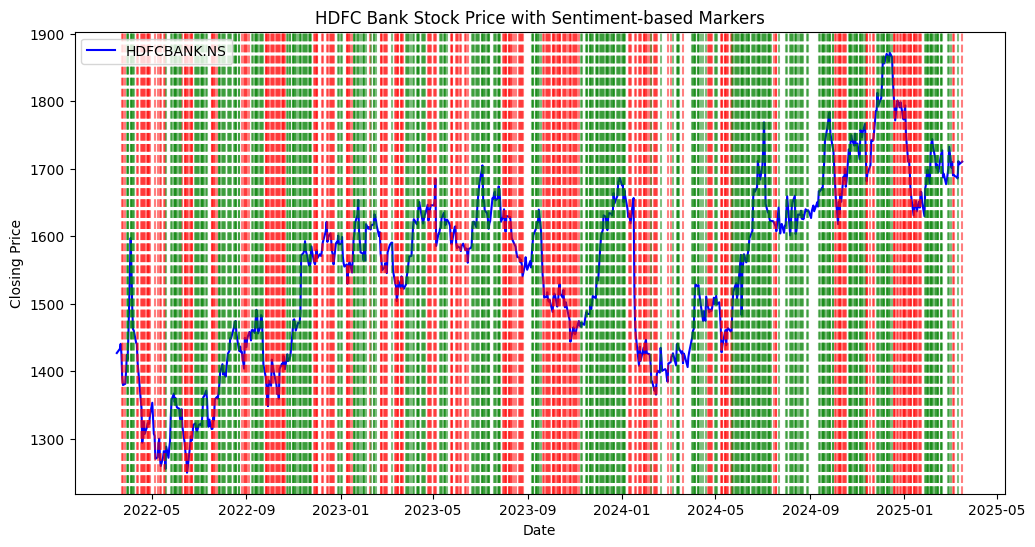

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv("HDFCBANK_Merged.csv")

# Convert date to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Calculate rolling average sentiment over a window (5 or 10 days)
window_size = 10  # Change to 5 if needed
df["Rolling_Sentiment"] = df["Sentiment"].rolling(window=window_size, min_periods=1).mean()

# Identify points where sentiment is significantly positive or negative
negative_sentiment = df[df["Rolling_Sentiment"] < 0]
positive_sentiment = df[df["Rolling_Sentiment"] > 0]

# Plot stock closing price
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="HDFCBANK.NS", color="blue")

# Add vertical lines for sentiment trends
for date in negative_sentiment["Date"]:
    plt.axvline(date, color="red", linestyle="--", alpha=0.5)

for date in positive_sentiment["Date"]:
    plt.axvline(date, color="green", linestyle="--", alpha=0.5)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("HDFC Bank Stock Price with Sentiment-based Markers")
plt.legend(["HDFCBANK.NS"])
plt.show()

### **RTGCN Model:**
This step onwards, the main prediction model is built

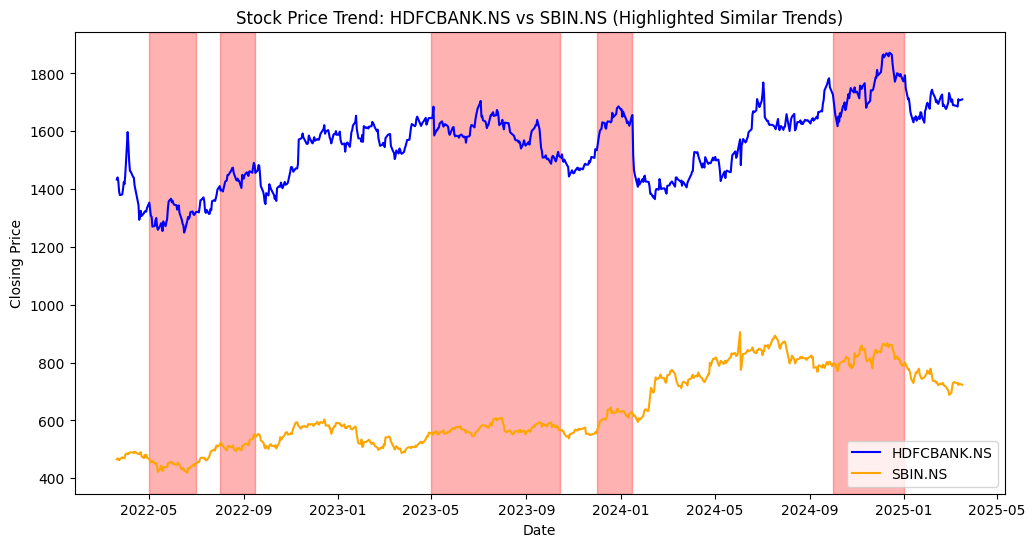

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df_hdfc = pd.read_csv("HDFCBANK.NS.csv")
df_sbi = pd.read_csv("SBIN.NS.csv")

# Convert date columns to datetime
df_hdfc["Date"] = pd.to_datetime(df_hdfc["Date"])
df_sbi["Date"] = pd.to_datetime(df_sbi["Date"])

# Merge both datasets on 'Date'
df = pd.merge(df_hdfc, df_sbi, on="Date", suffixes=("_HDFCBANK", "_SBIN"))

# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close_HDFCBANK"], label="HDFCBANK.NS", color="blue")
plt.plot(df["Date"], df["Close_SBIN"], label="SBIN.NS", color="orange")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Trend: HDFCBANK.NS vs SBIN.NS (Highlighted Similar Trends)")
plt.legend()

# Define the similar trend areas (Modify based on actual analysis)
highlight_areas = [
    ("2022-05-01", "2022-07-01"),
    ("2022-08-01", "2022-09-15"),
    ("2023-05-01", "2023-10-15"),
    ("2023-12-01", "2024-01-15"),
    ("2024-10-01", "2025-01-01"),
]

# Add rectangles for highlighting
for start, end in highlight_areas:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    plt.axvspan(start_date, end_date, color="red", alpha=0.3)  # Transparent red box

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RTGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_relations, time_steps):
        super(RTGCN, self).__init__()

        # Relational Graph Convolution Layers
        self.rgcn1 = RelGraphConv(input_dim, hidden_dim, num_relations, activation=F.relu)
        self.rgcn2 = RelGraphConv(hidden_dim, hidden_dim, num_relations, activation=F.relu)

        # Temporal Convolution Layer (1D Conv to capture temporal dependencies)
        self.temporal_conv = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_type):
        """
        x: Node features (batch_size, num_nodes, input_dim)
        edge_index: Graph edges (2, num_edges)
        edge_type: Relation types (num_edges)
        """

        # Apply Relational Graph Convolution
        x = self.rgcn1(x, edge_index, edge_type)
        x = self.rgcn2(x, edge_index, edge_type)

        # Apply Temporal Convolution
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, features, num_nodes)
        x = self.temporal_conv(x)
        x = x.permute(0, 2, 1)  # Change back to (batch_size, num_nodes, features)

        # Fully Connected Output Layer
        x = self.fc(x)
        return x

# Custom Pairwise Ranking Loss
class PairwiseRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(PairwiseRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, scores, true_ranking):
        """
        scores: Predicted ranking scores for stocks
        true_ranking: Ground truth rankings
        """
        loss = 0.0
        num_pairs = 0
        for i in range(len(scores)):
            for j in range(i+1, len(scores)):
                target = torch.sign(true_ranking[i] - true_ranking[j])
                loss += F.relu(self.margin - target * (scores[i] - scores[j]))
                num_pairs += 1
        return loss / num_pairs if num_pairs > 0 else loss

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Define stock-sector mapping
sector_data = {
    "Ticker": ["HDFCBANK.NS", "RELIANCE.NS", "TCS.NS", "INFY.NS", "SBIN.NS"],
    "Sector": ["Banking", "Oil & Gas", "IT", "IT", "Banking"]
}

# Create DataFrame
df_sector = pd.DataFrame(sector_data)

# Save as CSV
df_sector.to_csv("sector_info.csv", index=False)

print("✅ Sector information file created: sector_info.csv")


✅ Sector information file created: sector_info.csv


In [ ]:
import yfinance as yf

# Define the stock ticker and time period
tickers = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "SBIN.NS"]
period = "3y"

# Download historical data
for ticker in tickers:
  df = yf.download(ticker, period=period,interval="1d")

  # Save to CSV
  csv_filename = f"{ticker}_data.csv"
  df.to_csv(csv_filename)

  print(f"Data saved to {csv_filename}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data saved to RELIANCE.NS_data.csv


[*********************100%***********************]  1 of 1 completed


Data saved to TCS.NS_data.csv


[*********************100%***********************]  1 of 1 completed


Data saved to INFY.NS_data.csv


[*********************100%***********************]  1 of 1 completed

Data saved to SBIN.NS_data.csv


In [ ]:
import pandas as pd

# List of stock tickers
tickers = ["HDFCBANK.NS", "RELIANCE.NS", "TCS.NS", "INFY.NS", "SBIN.NS"]

for ticker in tickers:
    file_name = f"{ticker}_data.csv"  # Original misaligned file
    fixed_file_name = f"{ticker}_fixed.csv"  # New cleaned file

    try:
        # Load CSV, skipping the first two rows
        df = pd.read_csv(file_name, skiprows=2)

        # Rename columns correctly
        df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

        # Convert Date column to datetime format
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        # Convert numeric columns to float (ensures correct data type)
        numeric_cols = ["Close", "High", "Low", "Open", "Volume"]
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

        # Save cleaned data back to CSV
        df.to_csv(fixed_file_name, index=False)

        print(f"✅ Fixed and saved: {fixed_file_name}")

    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

✅ Fixed and saved: HDFCBANK.NS_fixed.csv
✅ Fixed and saved: RELIANCE.NS_fixed.csv
✅ Fixed and saved: TCS.NS_fixed.csv
✅ Fixed and saved: INFY.NS_fixed.csv
✅ Fixed and saved: SBIN.NS_fixed.csv


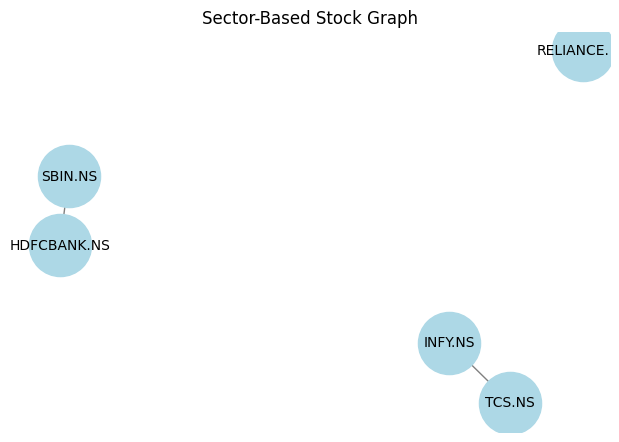

Graph saved to sector_graph.gml


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load sector info
sector_file = "sector_info.csv"
df_sector = pd.read_csv(sector_file)

# Create graph
G = nx.Graph()

# Add nodes (stocks)
stocks = df_sector["Ticker"].tolist()
G.add_nodes_from(stocks)

# Add edges (connect stocks in the same sector)
sector_groups = df_sector.groupby("Sector")["Ticker"].apply(list)
for sector, tickers in sector_groups.items():
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            G.add_edge(tickers[i], tickers[j], weight=1)  # Weight = 1 for same-sector links

# Save graph
graph_file = "sector_graph.gml"
nx.write_gml(G, graph_file)

# Visualize
plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Sector-Based Stock Graph")
plt.show()

print(f"Graph saved to {graph_file}")

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features (e.g., Close price, Sentiment)
features = torch.tensor(df[["Close", "Sentiment"]].values, dtype=torch.float)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model, loss, and optimizer
model = RTGCN(in_features=2, hidden_dim=16, out_features=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train RT-GCN
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index)
    loss = loss_fn(output.squeeze(), torch.tensor(df["Close"].values, dtype=torch.float))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

print("Training complete!")

Epoch 1/100, Loss: 1767911.1250
Epoch 2/100, Loss: 1641278.8750
Epoch 3/100, Loss: 1517936.7500
Epoch 4/100, Loss: 1398117.2500
Epoch 5/100, Loss: 1282032.7500
Epoch 6/100, Loss: 1169879.0000
Epoch 7/100, Loss: 1061836.8750
Epoch 8/100, Loss: 958073.0000
Epoch 9/100, Loss: 860805.0000
Epoch 10/100, Loss: 771104.9375
Epoch 11/100, Loss: 685184.3750
Epoch 12/100, Loss: 603324.2500
Epoch 13/100, Loss: 525806.2500
Epoch 14/100, Loss: 452910.2188
Epoch 15/100, Loss: 384907.4062
Epoch 16/100, Loss: 322056.2188
Epoch 17/100, Loss: 264593.5625
Epoch 18/100, Loss: 212725.8906
Epoch 19/100, Loss: 166618.1562
Epoch 20/100, Loss: 126381.2812
Epoch 21/100, Loss: 92058.4062
Epoch 22/100, Loss: 63610.7188
Epoch 23/100, Loss: 40903.7773
Epoch 24/100, Loss: 23695.5996
Epoch 25/100, Loss: 11629.4639
Epoch 26/100, Loss: 4231.6221
Epoch 27/100, Loss: 917.2999
Epoch 28/100, Loss: 1006.1882
Epoch 29/100, Loss: 3747.7351
Epoch 30/100, Loss: 8355.8047
Epoch 31/100, Loss: 14049.9580
Epoch 32/100, Loss: 20099.0

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.stats import spearmanr

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features (e.g., Close price, Sentiment)
features = torch.tensor(df[["Close", "Sentiment"]].values, dtype=torch.float)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Pairwise Ranking Loss
class PairwiseRankingLoss(nn.Module):
    def forward(self, predictions, targets):
        pairwise_diffs = predictions.unsqueeze(1) - predictions.unsqueeze(0)
        target_diffs = targets.unsqueeze(1) - targets.unsqueeze(0)
        loss = torch.mean(torch.relu(-pairwise_diffs * target_diffs))
        return loss

# Initialize model, loss, and optimizer
model = RTGCN(in_features=2, hidden_dim=16, out_features=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = PairwiseRankingLoss()

# Train RT-GCN
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index).squeeze()
    targets = torch.tensor(df["Close"].values, dtype=torch.float)
    loss = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

# Evaluate using Spearman's Rank Correlation
model.eval()
with torch.no_grad():
    predictions = model(features, edge_index).squeeze().numpy()
    true_values = df["Close"].values
    spearman_corr, _ = spearmanr(predictions, true_values)
    print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")

print("Training complete!")

Epoch 1/100, Loss: 23.8070
Epoch 2/100, Loss: 17.3286
Epoch 3/100, Loss: 10.9690
Epoch 4/100, Loss: 4.7524
Epoch 5/100, Loss: 237.2305
Epoch 6/100, Loss: 2.0954
Epoch 7/100, Loss: 4.7400
Epoch 8/100, Loss: 7.1915
Epoch 9/100, Loss: 9.3618
Epoch 10/100, Loss: 11.2851
Epoch 11/100, Loss: 12.9934
Epoch 12/100, Loss: 14.5136
Epoch 13/100, Loss: 15.8679
Epoch 14/100, Loss: 17.0749
Epoch 15/100, Loss: 18.1501
Epoch 16/100, Loss: 19.1070
Epoch 17/100, Loss: 19.9573
Epoch 18/100, Loss: 20.7110
Epoch 19/100, Loss: 21.3773
Epoch 20/100, Loss: 21.9640
Epoch 21/100, Loss: 22.4782
Epoch 22/100, Loss: 22.9263
Epoch 23/100, Loss: 23.3140
Epoch 24/100, Loss: 23.6463
Epoch 25/100, Loss: 23.9281
Epoch 26/100, Loss: 24.1634
Epoch 27/100, Loss: 24.3561
Epoch 28/100, Loss: 24.5097
Epoch 29/100, Loss: 24.6274
Epoch 30/100, Loss: 24.7120
Epoch 31/100, Loss: 24.7663
Epoch 32/100, Loss: 24.7926
Epoch 33/100, Loss: 24.7931
Epoch 34/100, Loss: 24.7698
Epoch 35/100, Loss: 24.7247
Epoch 36/100, Loss: 24.6593
Epoch

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features (e.g., Close price, Sentiment)
def prepare_features(dataframe):
    return torch.tensor(dataframe[["Close", "Sentiment"]].values, dtype=torch.float)

train_features = prepare_features(train_df)
test_features = prepare_features(test_df)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Pairwise Ranking Loss
class PairwiseRankingLoss(nn.Module):
    def forward(self, predictions, targets):
        pairwise_diffs = predictions.unsqueeze(1) - predictions.unsqueeze(0)
        target_diffs = targets.unsqueeze(1) - targets.unsqueeze(0)
        loss = torch.mean(torch.relu(-pairwise_diffs * target_diffs))
        return loss

# Initialize model, loss, and optimizer
model = RTGCN(in_features=2, hidden_dim=16, out_features=1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = PairwiseRankingLoss()

# Train RT-GCN
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(train_features, edge_index).squeeze()
    targets = torch.tensor(train_df["Close"].values, dtype=torch.float)
    loss = loss_fn(output, targets)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

# Evaluate using Spearman's Rank Correlation
model.eval()
with torch.no_grad():
    test_predictions = model(test_features, edge_index).squeeze().numpy()
    test_true_values = test_df["Close"].values
    spearman_corr, _ = spearmanr(test_predictions, test_true_values)
    print(f"Spearman's Rank Correlation on Test Set: {spearman_corr:.4f}")

print("Training complete!")

Epoch 1/100, Loss: 2312.7786
Epoch 2/100, Loss: 1485.9589
Epoch 3/100, Loss: 664.3539
Epoch 4/100, Loss: 1.7229
Epoch 5/100, Loss: 7.4158
Epoch 6/100, Loss: 12.3886
Epoch 7/100, Loss: 16.6416
Epoch 8/100, Loss: 20.3244
Epoch 9/100, Loss: 23.5426
Epoch 10/100, Loss: 26.0684
Epoch 11/100, Loss: 28.2280
Epoch 12/100, Loss: 30.1465
Epoch 13/100, Loss: 31.8543
Epoch 14/100, Loss: 33.3766
Epoch 15/100, Loss: 34.7344
Epoch 16/100, Loss: 35.9456
Epoch 17/100, Loss: 37.0254
Epoch 18/100, Loss: 37.9871
Epoch 19/100, Loss: 38.8424
Epoch 20/100, Loss: 39.6013
Epoch 21/100, Loss: 40.2728
Epoch 22/100, Loss: 40.8651
Epoch 23/100, Loss: 41.3852
Epoch 24/100, Loss: 41.8395
Epoch 25/100, Loss: 42.2338
Epoch 26/100, Loss: 42.5735
Epoch 27/100, Loss: 42.8630
Epoch 28/100, Loss: 43.1067
Epoch 29/100, Loss: 43.3085
Epoch 30/100, Loss: 43.4719
Epoch 31/100, Loss: 43.6001
Epoch 32/100, Loss: 43.6960
Epoch 33/100, Loss: 43.7622
Epoch 34/100, Loss: 43.8012
Epoch 35/100, Loss: 43.8153
Epoch 36/100, Loss: 43.806

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features (with and without sentiment)
def prepare_features(dataframe, use_sentiment=True):
    if use_sentiment:
        return torch.tensor(dataframe[["Close", "Sentiment"]].values, dtype=torch.float)
    else:
        return torch.tensor(dataframe[["Close"]].values, dtype=torch.float)

# Train and evaluate function
def train_and_evaluate(use_sentiment=True):
    train_features = prepare_features(train_df, use_sentiment)
    test_features = prepare_features(test_df, use_sentiment)

    # Define RT-GCN model
    class RTGCN(nn.Module):
        def __init__(self, in_features, hidden_dim, out_features):
            super(RTGCN, self).__init__()
            self.conv1 = GCNConv(in_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_features)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    # Pairwise Ranking Loss
    class PairwiseRankingLoss(nn.Module):
        def forward(self, predictions, targets):
            pairwise_diffs = predictions.unsqueeze(1) - predictions.unsqueeze(0)
            target_diffs = targets.unsqueeze(1) - targets.unsqueeze(0)
            loss = torch.mean(torch.relu(-pairwise_diffs * target_diffs))
            return loss

    # Initialize model, loss, and optimizer
    in_features = 2 if use_sentiment else 1
    model = RTGCN(in_features=in_features, hidden_dim=16, out_features=1)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = PairwiseRankingLoss()

    # Train RT-GCN
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(train_features, edge_index).squeeze()
        targets = torch.tensor(train_df["Close"].values, dtype=torch.float)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

    # Evaluate using Spearman's Rank Correlation
    model.eval()
    with torch.no_grad():
        test_predictions = model(test_features, edge_index).squeeze().numpy()
        test_true_values = test_df["Close"].values
        spearman_corr, _ = spearmanr(test_predictions, test_true_values)
        sentiment_status = "with Sentiment" if use_sentiment else "without Sentiment"
        print(f"Spearman's Rank Correlation on Test Set {sentiment_status}: {spearman_corr:.4f}")

    print(f"Training complete for model {sentiment_status}!")

# Train and evaluate with sentiment
train_and_evaluate(use_sentiment=True)

# Train and evaluate without sentiment
train_and_evaluate(use_sentiment=False)

Epoch 1/100, Loss: 7353.1323
Epoch 2/100, Loss: 5352.1636
Epoch 3/100, Loss: 3366.3511
Epoch 4/100, Loss: 1395.9064
Epoch 5/100, Loss: 5.0152
Epoch 6/100, Loss: 19.6723
Epoch 7/100, Loss: 32.1917
Epoch 8/100, Loss: 43.0313
Epoch 9/100, Loss: 52.5066
Epoch 10/100, Loss: 60.8475
Epoch 11/100, Loss: 68.2282
Epoch 12/100, Loss: 74.7846
Epoch 13/100, Loss: 80.6258
Epoch 14/100, Loss: 85.8408
Epoch 15/100, Loss: 90.5036
Epoch 16/100, Loss: 94.6767
Epoch 17/100, Loss: 98.4133
Epoch 18/100, Loss: 101.7590
Epoch 19/100, Loss: 104.7540
Epoch 20/100, Loss: 107.4328
Epoch 21/100, Loss: 109.8262
Epoch 22/100, Loss: 111.9611
Epoch 23/100, Loss: 113.8618
Epoch 24/100, Loss: 115.5498
Epoch 25/100, Loss: 117.0442
Epoch 26/100, Loss: 118.3624
Epoch 27/100, Loss: 119.5200
Epoch 28/100, Loss: 120.5311
Epoch 29/100, Loss: 121.4084
Epoch 30/100, Loss: 122.1633
Epoch 31/100, Loss: 122.8063
Epoch 32/100, Loss: 123.3470
Epoch 33/100, Loss: 123.7939
Epoch 34/100, Loss: 124.1549
Epoch 35/100, Loss: 124.4372
Epoc

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Compute rolling sentiment average
df["Sentiment_Rolling"] = df["Sentiment"].rolling(window=5, min_periods=1).mean()

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features (with and without sentiment)
def prepare_features(dataframe, use_sentiment=True):
    if use_sentiment:
        return torch.tensor(dataframe[["Close", "Sentiment_Rolling"]].values, dtype=torch.float)
    else:
        return torch.tensor(dataframe[["Close"]].values, dtype=torch.float)

# Train and evaluate function
def train_and_evaluate(use_sentiment=True):
    train_features = prepare_features(train_df, use_sentiment)
    test_features = prepare_features(test_df, use_sentiment)

    # Define RT-GCN model
    class RTGCN(nn.Module):
        def __init__(self, in_features, hidden_dim, out_features):
            super(RTGCN, self).__init__()
            self.conv1 = GCNConv(in_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_features)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    # Pairwise Ranking Loss
    class PairwiseRankingLoss(nn.Module):
        def forward(self, predictions, targets):
            pairwise_diffs = predictions.unsqueeze(1) - predictions.unsqueeze(0)
            target_diffs = targets.unsqueeze(1) - targets.unsqueeze(0)
            loss = torch.mean(torch.relu(-pairwise_diffs * target_diffs))
            return loss

    # Initialize model, loss, and optimizer
    in_features = 2 if use_sentiment else 1
    model = RTGCN(in_features=in_features, hidden_dim=16, out_features=1)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = PairwiseRankingLoss()

    # Train RT-GCN
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(train_features, edge_index).squeeze()
        targets = torch.tensor(train_df["Close"].values, dtype=torch.float)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

    # Evaluate using Spearman's Rank Correlation
    model.eval()
    with torch.no_grad():
        test_predictions = model(test_features, edge_index).squeeze().numpy()
        test_true_values = test_df["Close"].values
        spearman_corr, _ = spearmanr(test_predictions, test_true_values)
        sentiment_status = "with Rolling Sentiment" if use_sentiment else "without Sentiment"
        print(f"Spearman's Rank Correlation on Test Set {sentiment_status}: {spearman_corr:.4f}")

    print(f"Training complete for model {sentiment_status}!")

# Train and evaluate with rolling sentiment
train_and_evaluate(use_sentiment=True)

# Train and evaluate without sentiment
train_and_evaluate(use_sentiment=False)

Epoch 1/100, Loss: 6159.5400
Epoch 2/100, Loss: 5035.2935
Epoch 3/100, Loss: 3931.1924
Epoch 4/100, Loss: 2847.3303
Epoch 5/100, Loss: 1783.3130
Epoch 6/100, Loss: 737.8863
Epoch 7/100, Loss: 2.6141
Epoch 8/100, Loss: 10.5399
Epoch 9/100, Loss: 17.4293
Epoch 10/100, Loss: 23.4653
Epoch 11/100, Loss: 28.7855
Epoch 12/100, Loss: 33.4966
Epoch 13/100, Loss: 37.6833
Epoch 14/100, Loss: 41.4143
Epoch 15/100, Loss: 44.7464
Epoch 16/100, Loss: 47.7269
Epoch 17/100, Loss: 50.3958
Epoch 18/100, Loss: 52.7874
Epoch 19/100, Loss: 54.9313
Epoch 20/100, Loss: 56.8531
Epoch 21/100, Loss: 58.5752
Epoch 22/100, Loss: 60.1173
Epoch 23/100, Loss: 61.4970
Epoch 24/100, Loss: 62.7295
Epoch 25/100, Loss: 63.8287
Epoch 26/100, Loss: 64.8070
Epoch 27/100, Loss: 65.6754
Epoch 28/100, Loss: 66.4438
Epoch 29/100, Loss: 67.1212
Epoch 30/100, Loss: 67.7155
Epoch 31/100, Loss: 68.2342
Epoch 32/100, Loss: 68.6839
Epoch 33/100, Loss: 69.0704
Epoch 34/100, Loss: 69.3994
Epoch 35/100, Loss: 69.6757
Epoch 36/100, Loss:

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Compute rolling sentiment average
df["Sentiment_Rolling"] = df["Sentiment"].rolling(window=5, min_periods=1).mean()

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features
def prepare_features(dataframe):
    return torch.tensor(dataframe[["Close", "Sentiment_Rolling"]].values, dtype=torch.float)

# Train function
def train_model():
    train_features = prepare_features(train_df)
    test_features = prepare_features(test_df)

    # Define RT-GCN model
    class RTGCN(nn.Module):
        def __init__(self, in_features, hidden_dim, out_features):
            super(RTGCN, self).__init__()
            self.conv1 = GCNConv(in_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_features)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    # Pairwise Ranking Loss
    class PairwiseRankingLoss(nn.Module):
        def forward(self, predictions, targets):
            pairwise_diffs = predictions.unsqueeze(1) - predictions.unsqueeze(0)
            target_diffs = targets.unsqueeze(1) - targets.unsqueeze(0)
            loss = torch.mean(torch.relu(-pairwise_diffs * target_diffs))
            return loss

    # Initialize model, loss, and optimizer
    model = RTGCN(in_features=2, hidden_dim=16, out_features=1)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = PairwiseRankingLoss()

    # Train RT-GCN
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(train_features, edge_index).squeeze()
        targets = torch.tensor(train_df["Close"].values, dtype=torch.float)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

    # Save trained model
    model_path = "rtgcn_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Train and save the model
train_model()

Epoch 1/100, Loss: 34.3850
Epoch 2/100, Loss: 23.7206
Epoch 3/100, Loss: 13.1033
Epoch 4/100, Loss: 2.5369
Epoch 5/100, Loss: 831.4742
Epoch 6/100, Loss: 274.4611
Epoch 7/100, Loss: 3.9916
Epoch 8/100, Loss: 9.6426
Epoch 9/100, Loss: 14.5937
Epoch 10/100, Loss: 18.9584
Epoch 11/100, Loss: 22.8233
Epoch 12/100, Loss: 26.2565
Epoch 13/100, Loss: 29.3127
Epoch 14/100, Loss: 32.0371
Epoch 15/100, Loss: 34.4672
Epoch 16/100, Loss: 36.6348
Epoch 17/100, Loss: 38.5675
Epoch 18/100, Loss: 40.2889
Epoch 19/100, Loss: 41.8196
Epoch 20/100, Loss: 43.1779
Epoch 21/100, Loss: 44.3798
Epoch 22/100, Loss: 45.4398
Epoch 23/100, Loss: 46.3704
Epoch 24/100, Loss: 47.1831
Epoch 25/100, Loss: 47.8885
Epoch 26/100, Loss: 48.4956
Epoch 27/100, Loss: 49.0129
Epoch 28/100, Loss: 49.4480
Epoch 29/100, Loss: 49.8079
Epoch 30/100, Loss: 50.0988
Epoch 31/100, Loss: 50.3264
Epoch 32/100, Loss: 50.4961
Epoch 33/100, Loss: 50.6124
Epoch 34/100, Loss: 50.6798
Epoch 35/100, Loss: 50.7022
Epoch 36/100, Loss: 50.6832
Ep

Epoch 0, Loss: 0.23608073592185974
Epoch 10, Loss: 0.03650343790650368
Epoch 20, Loss: 0.013237337581813335
Epoch 30, Loss: 0.004011846613138914
Epoch 40, Loss: 0.0018950821831822395
Epoch 50, Loss: 0.0007797338766977191
Epoch 60, Loss: 0.00029457348864525557
Epoch 70, Loss: 0.00019385451741982251
Epoch 80, Loss: 0.00014459321391768754
Epoch 90, Loss: 9.928511281032115e-05
RMSE: 0.0093
Spearman's Rank Correlation: 0.9992


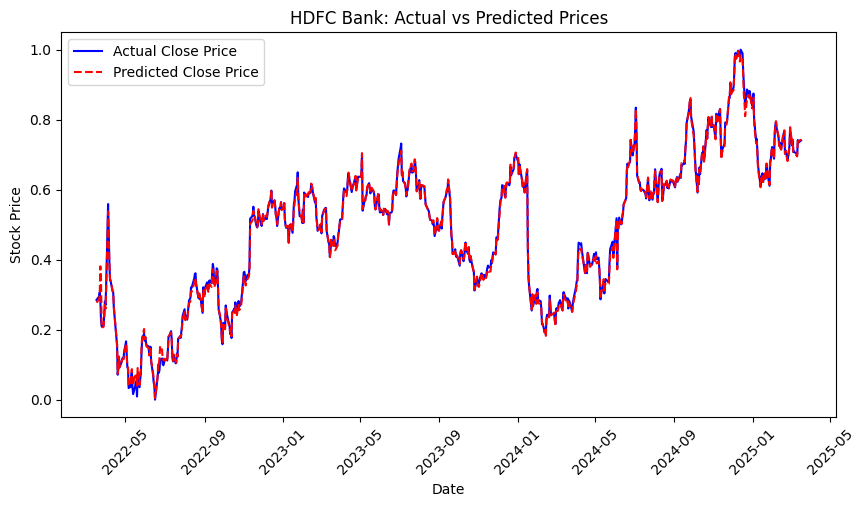

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
import numpy as np

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Compute rolling sentiment average
df["Sentiment_Rolling"] = df["Sentiment"].rolling(window=5, min_periods=1).mean()

# Normalize features
scaler = MinMaxScaler()
df[["Close", "Sentiment_Rolling"]] = scaler.fit_transform(df[["Close", "Sentiment_Rolling"]])

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features
def prepare_features(dataframe):
    return torch.tensor(dataframe[["Close", "Sentiment_Rolling"]].values, dtype=torch.float)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Train new model
model = RTGCN(in_features=2, hidden_dim=32, out_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

features = prepare_features(df)
target = torch.tensor(df["Close"].values, dtype=torch.float).unsqueeze(1)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict and evaluate
def evaluate_model():
    model.eval()
    with torch.no_grad():
        predictions = model(features, edge_index).squeeze().numpy()

    actuals = df["Close"].values
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    spearman_corr, _ = spearmanr(actuals, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(df["Date"], df["Close"], label="Actual Close Price", color='blue')
    plt.plot(df["Date"], predictions, label="Predicted Close Price", linestyle='dashed', color='red')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("HDFC Bank: Actual vs Predicted Prices")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Run evaluation
evaluate_model()

Epoch 0, Loss: 0.3611299991607666
Epoch 10, Loss: 0.054746851325035095
Epoch 20, Loss: 0.011190257966518402
Epoch 30, Loss: 0.009218704886734486
Epoch 40, Loss: 0.006545054726302624
Epoch 50, Loss: 0.0034714967478066683
Epoch 60, Loss: 0.001971601275727153
Epoch 70, Loss: 0.0011889142915606499
Epoch 80, Loss: 0.0007209951290860772
Epoch 90, Loss: 0.00044821976916864514
Train RMSE: 0.0171, Test RMSE: 0.0181
Train Spearman's Rank Correlation: 0.9962, Test Spearman's Rank Correlation: 0.9982


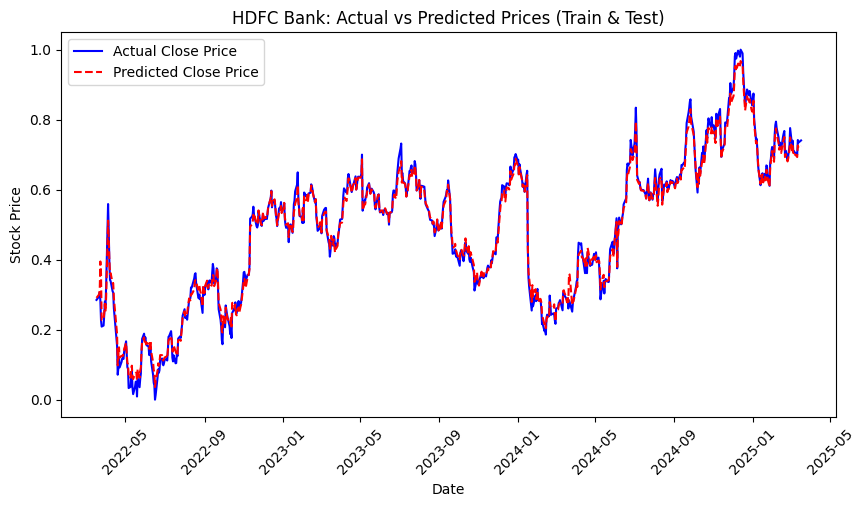

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
import numpy as np

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Compute rolling sentiment average
df["Sentiment_Rolling"] = df["Sentiment"].rolling(window=5, min_periods=1).mean()

# Normalize features
scaler = MinMaxScaler()
df[["Close", "Sentiment_Rolling"]] = scaler.fit_transform(df[["Close", "Sentiment_Rolling"]])

# Split data into training (first 2 years) and testing (latest 1 year)
train_size = int(len(df) * 2 / 3)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features
def prepare_features(dataframe):
    return torch.tensor(dataframe[["Close", "Sentiment_Rolling"]].values, dtype=torch.float)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Train new model
model = RTGCN(in_features=2, hidden_dim=32, out_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

features_train = prepare_features(df_train)
target_train = torch.tensor(df_train["Close"].values, dtype=torch.float).unsqueeze(1)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(features_train, edge_index)
    loss = criterion(output, target_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict and evaluate
def evaluate_model():
    model.eval()
    with torch.no_grad():
        predictions_train = model(prepare_features(df_train), edge_index).squeeze().numpy()
        predictions_test = model(prepare_features(df_test), edge_index).squeeze().numpy()

    actuals_train = df_train["Close"].values
    actuals_test = df_test["Close"].values
    rmse_train = np.sqrt(np.mean((predictions_train - actuals_train) ** 2))
    rmse_test = np.sqrt(np.mean((predictions_test - actuals_test) ** 2))
    spearman_corr_train, _ = spearmanr(actuals_train, predictions_train)
    spearman_corr_test, _ = spearmanr(actuals_test, predictions_test)

    print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")
    print(f"Train Spearman's Rank Correlation: {spearman_corr_train:.4f}, Test Spearman's Rank Correlation: {spearman_corr_test:.4f}")

    # Plot actual vs predicted for full 3 years
    plt.figure(figsize=(10, 5))
    plt.plot(df["Date"], df["Close"], label="Actual Close Price", color='blue')
    full_predictions = np.concatenate([predictions_train, predictions_test])
    plt.plot(df["Date"], full_predictions, label="Predicted Close Price", linestyle='dashed', color='red')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("HDFC Bank: Actual vs Predicted Prices (Train & Test)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Run evaluation
evaluate_model()

Epoch 0, Loss: 0.4049738347530365
Epoch 10, Loss: 0.07519158720970154
Epoch 20, Loss: 0.018797531723976135
Epoch 30, Loss: 0.006287438329309225
Epoch 40, Loss: 0.0026389306876808405
Epoch 50, Loss: 0.0009560592588968575
Epoch 60, Loss: 0.00031995083554647863
Epoch 70, Loss: 0.00022883516794536263
Epoch 80, Loss: 0.00018515536794438958
Epoch 90, Loss: 0.00012418825644999743
Train RMSE: 0.0102, Test RMSE: 0.0624
Train Spearman's Rank Correlation: 0.9975, Test Spearman's Rank Correlation: 0.9465


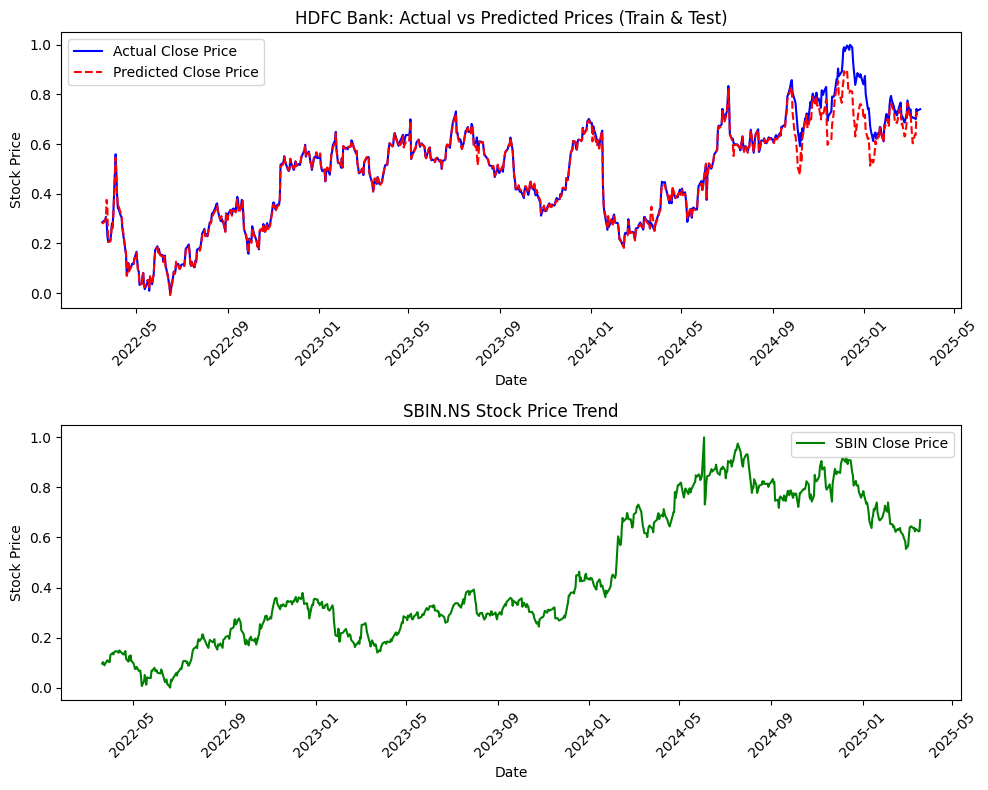

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr
import numpy as np

# Load merged stock & sentiment data
data_file = "HDFCBANK_Merged.csv"
df = pd.read_csv(data_file, parse_dates=["Date"])

# Load SBIN stock data
sbin_file = "SBIN.NS.csv"
df_sbin = pd.read_csv(sbin_file, parse_dates=["Date"])

# Compute rolling sentiment average
df["Sentiment_Rolling"] = df["Sentiment"].rolling(window=5, min_periods=1).mean()

# Normalize features
scaler = MinMaxScaler()
df[["Close", "Sentiment_Rolling"]] = scaler.fit_transform(df[["Close", "Sentiment_Rolling"]])
df_sbin["Close"] = scaler.fit_transform(df_sbin[["Close"]])

# Split data into training (first 2 years) and testing (latest 1 year)
train_size = int(len(df) * 2 / 3)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

# Load sector-based graph
graph_file = "sector_graph.gml"
G = nx.read_gml(graph_file)

# Map stock tickers to numerical indices
node_mapping = {node: i for i, node in enumerate(G.nodes)}

# Convert graph edges to numerical indices
edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()

# Prepare node features
def prepare_features(dataframe):
    return torch.tensor(dataframe[["Close", "Sentiment_Rolling"]].values, dtype=torch.float)

# Define RT-GCN model
class RTGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(RTGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Train new model
model = RTGCN(in_features=2, hidden_dim=32, out_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

features_train = prepare_features(df_train)
target_train = torch.tensor(df_train["Close"].values, dtype=torch.float).unsqueeze(1)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(features_train, edge_index)
    loss = criterion(output, target_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Predict and evaluate
def evaluate_model():
    model.eval()
    with torch.no_grad():
        predictions_train = model(prepare_features(df_train), edge_index).squeeze().numpy()
        predictions_test = model(prepare_features(df_test), edge_index).squeeze().numpy()

    actuals_train = df_train["Close"].values
    actuals_test = df_test["Close"].values
    rmse_train = np.sqrt(np.mean((predictions_train - actuals_train) ** 2))
    rmse_test = np.sqrt(np.mean((predictions_test - actuals_test) ** 2))
    spearman_corr_train, _ = spearmanr(actuals_train, predictions_train)
    spearman_corr_test, _ = spearmanr(actuals_test, predictions_test)

    print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")
    print(f"Train Spearman's Rank Correlation: {spearman_corr_train:.4f}, Test Spearman's Rank Correlation: {spearman_corr_test:.4f}")

    # Plot actual vs predicted for full 3 years
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.plot(df["Date"], df["Close"], label="Actual Close Price", color='blue')
    full_predictions = np.concatenate([predictions_train, predictions_test])
    plt.plot(df["Date"], full_predictions, label="Predicted Close Price", linestyle='dashed', color='red')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("HDFC Bank: Actual vs Predicted Prices (Train & Test)")
    plt.legend()
    plt.xticks(rotation=45)

    # Plot SBIN price trend
    plt.subplot(2, 1, 2)
    plt.plot(df_sbin["Date"], df_sbin["Close"], label="SBIN Close Price", color='green')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("SBIN.NS Stock Price Trend")
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Run evaluation
evaluate_model()